In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, RobustScaler
#!pip install botorch

 #  Load the Dataset

In [2]:
train_df = pd.read_csv("Data/train.csv")
test_df = pd.read_csv("Data/test.csv")
y = train_df['SalePrice']

Right off the bat we notice two very large & cheap houses. 

<AxesSubplot:xlabel='GrLivArea', ylabel='SalePrice'>

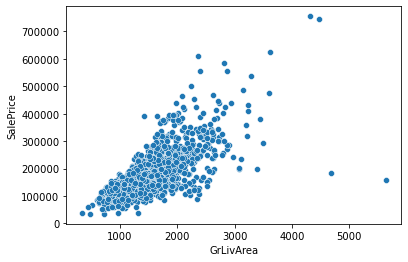

In [3]:
sns.scatterplot(x=train_df['GrLivArea'],y=y)

In [4]:
train_df.drop(train_df[(train_df['GrLivArea'] > 4000) & (train_df['SalePrice'] < 300000)].index, axis=0, inplace=True)
# Concatenate train and test data for pre-processing
X = pd.concat([train_df.drop('SalePrice',axis=1),test_df], axis=0)
X.drop('Id',axis=1, inplace= True)
y = train_df['SalePrice']

In [5]:
# pd.set_option("display.max_rows", None)
X_null = X.isnull().sum()/X.shape[0]*100 # check for missing values
pd.DataFrame(X_null.rename('% NaN').sort_values(ascending= False)).style.background_gradient(cmap= 'PuBu',vmin=0, vmax=100).format(precision=2)

,% NaN
PoolQC,99.69
MiscFeature,96.40
Alley,93.21
Fence,80.43
FireplaceQu,48.68
LotFrontage,16.66
GarageYrBlt,5.45
GarageFinish,5.45
GarageQual,5.45
GarageCond,5.45


In [6]:
ch = X.select_dtypes('object')
columns_unq = ch.apply('nunique').loc[lambda x: x<20].index
# Unique values for most non-numeric features
uniq_df = pd.DataFrame((c,[x for x in ch[c].unique()]) for c in columns_unq)


In [7]:
uniq_df

,0,1
0,MSZoning,"[RL, RM, C (all), FV, RH, nan]"
1,Street,"[Pave, Grvl]"
2,Alley,"[nan, Grvl, Pave]"
3,LotShape,"[Reg, IR1, IR2, IR3]"
4,LandContour,"[Lvl, Bnk, Low, HLS]"
5,Utilities,"[AllPub, NoSeWa, nan]"
6,LotConfig,"[Inside, FR2, Corner, CulDSac, FR3]"
7,LandSlope,"[Gtl, Mod, Sev]"
8,Condition1,"[Norm, Feedr, PosN, Artery, RRAe, RRNn, RRAn, ..."
9,Condition2,"[Norm, Artery, RRNn, Feedr, PosA, PosN, RRAn, ..."


In [8]:
dict_clean = {
    "Exterior2nd": {"CmentBd": "CemntBd",
                    "Brk Cmn":"BrkComm",
                    "Wd Shng": "WdShing"}
}
X.replace(dict_clean,inplace= True)

In [9]:
X[['Alley','FireplaceQu','BsmtQual','BsmtCond','BsmtExposure',
          'BsmtFinType1','BsmtFinType2','GarageType','GarageFinish','GarageQual'
          ,'GarageCond','Fence','MiscFeature','PoolQC', 'MasVnrType']] = X[['Alley','FireplaceQu','BsmtQual','BsmtCond','BsmtExposure',
          'BsmtFinType1','BsmtFinType2','GarageType','GarageFinish','GarageQual'
          ,'GarageCond','Fence','MiscFeature','PoolQC', 'MasVnrType']].fillna('None')

X[['Exterior1st','MSZoning','Exterior2nd','Electrical','KitchenQual',
          'Functional','SaleType','Utilities']] = X[['Exterior1st','MSZoning','Exterior2nd','Electrical','KitchenQual',
          'Functional','SaleType','Utilities']].fillna({'Exterior1st':'VinylSd',
                                                        'MSZoning':'RL','Exterior2nd':'VinylSd','Electrical':'SBrkr',
                                                       'KitchenQual':'TA','Functional':'Typ','SaleType':'WD',
                                                       'Utilities':'AllPub'})

In [10]:
X[['MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF',
          'TotalBsmtSF','BsmtFullBath','BsmtHalfBath','GarageCars',
          'GarageArea','GarageYrBlt']] = X[['MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF',
          'TotalBsmtSF','BsmtFullBath','BsmtHalfBath','GarageCars','GarageArea','GarageYrBlt']].fillna(0)

X["LotFrontage"] = X.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))

In [11]:
print('There are still null values:', bool(X.isnull().sum().sum()))

There are still null values: False


# Exploratory Analysis

Notice the right-skewness of the target variable. If we want to fit linear models, SalePrice ought to follow a normal distribution.

<AxesSubplot:xlabel='SalePrice', ylabel='Count'>

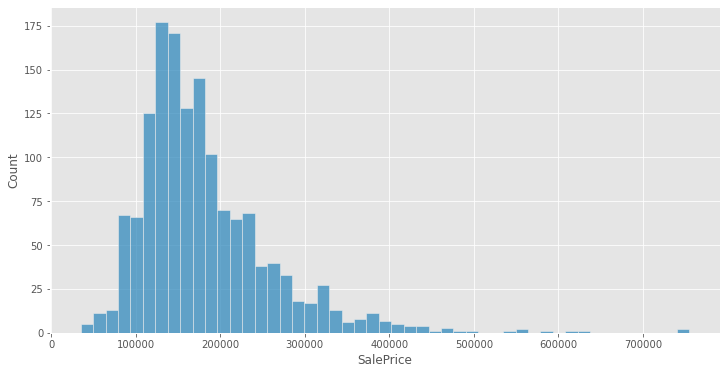

In [12]:
plt.style.use('ggplot')
fig, axs = plt.subplots(1, 1, figsize=(12, 6))
sns.histplot(data=y)

In [13]:
# from sklearn.preprocessing import PowerTransformer
# ptr = PowerTransformer(method='box-cox',standardize= False)
# y_norm = pd.DataFrame(ptr.fit_transform(y.to_frame()))
y_proc = np.log(y)

<AxesSubplot:xlabel='SalePrice', ylabel='Count'>

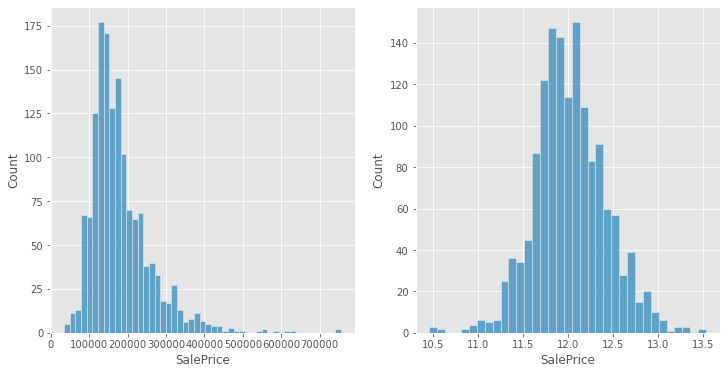

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
sns.histplot(data=y, ax= axs[0], label = 'Before')
sns.histplot(data=y_proc, ax= axs[1], label= 'After')

In [15]:
# import statsmodels.api as sm
# f, axes = plt.subplots(80,2, figsize=(12, 320))
# for i, ftr in enumerate(X.columns):
#     sns.histplot(data=X[ftr],  ax = axes[i,0])
#     sm.qqplot(X[ftr], ax= axes[i,1],fmt='k')

<AxesSubplot:>

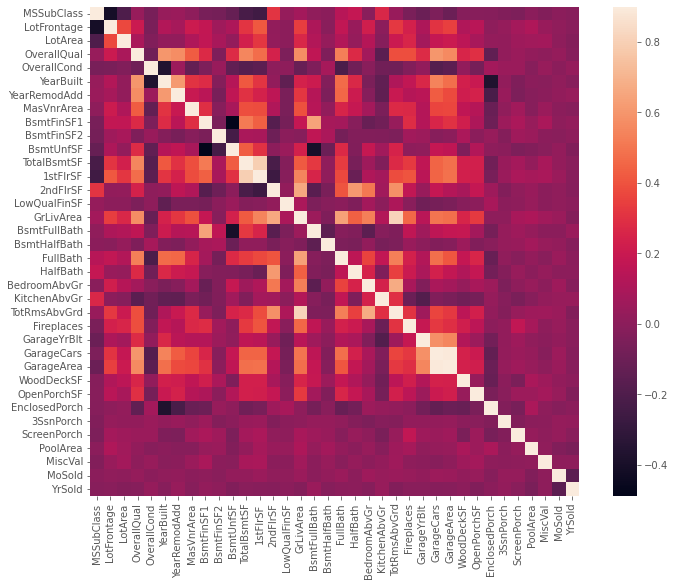

In [16]:
corr = X.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corr, vmax=0.9, square=True)

In [17]:
X['TotalSF'] = X['TotalBsmtSF'] + X['1stFlrSF'] + X['2ndFlrSF']

In [18]:
from sklearn.preprocessing import LabelEncoder

cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')

# apply LabelEncoder to categorical features
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(X[c].values)) 
    X[c] = lbl.transform(list(X[c].values))

In [19]:
X_f = pd.get_dummies(X)
X_tr = X_f[:train_df.shape[0]]
X_ts = X_f[train_df.shape[0]:]
# X_proc = pd.DataFrame(RobustScaler().fit_transform(X_f))

# X_procs = pd.DataFrame(StandardScaler().fit_transform(X_proc))

# X_train = X_proc[:train_df.shape[0]]
# X_test = X_proc[train_df.shape[0]:]

# X_trains = X_procs[:train_df.shape[0]]
# X_tests = X_procs[train_df.shape[0]:]

In [20]:
from sklearn.linear_model import RidgeCV

# Outlier detection based on linear model

def outl_excl(X, y1,y2 ):
    y_pred_lr = RidgeCV().fit(X, y1).predict(X_train)
    resid = pd.DataFrame(y1 - y_pred_lr).squeeze()
    outliers = ((resid - resid.mean()) / resid.std()).abs() > 3
    
    X = X.loc[~outliers, :].reset_index(drop=True)
    y1 = y1.loc[~outliers].reset_index(drop=True)
    y2 = y2.loc[~outliers].reset_index(drop=True)
    
    return X, y1,y2, y_pred_lr, outliers

# X, y_norm, y_proc, y_pred_lr, out = outl_excl(X_train,y_norm1,y_proc)
# sns.scatterplot(x=y_norm1.squeeze(), y=y_pred_lr.ravel(), hue=out)

# Modelling

In [22]:
from sklearn.svm import SVR
# import xgboost as xgb

from joblib import parallel_backend
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import ElasticNet
#import lightgbm as lgb

# Optuna for hyperparameter optimization
import optuna
from utils import trials


In [23]:
rng = 9
folds = KFold(n_splits=5, shuffle=True, random_state=rng)
def score(mod, X,y):
    score = -cross_val_score(mod, X,y,cv = folds, scoring = 'neg_root_mean_squared_error').mean()
    
    return score


In [28]:
trial = trials(X_tr, y_proc, score = score, folds = folds, transformation = RobustScaler())

In [ ]:
# XGBoost Hyperparameter optimization

pruner = optuna.pruners.MedianPruner(n_warmup_steps=100)
xgb_study = optuna.create_study(pruner=pruner, direction="minimize")
xgb_study.optimize(trial.objxgb, n_trials=100)

In [29]:
# Polynomial SVM Hyperparameter optimization

svmp = optuna.create_study( direction = 'minimize')
svmp.optimize(trial.objsvp,n_trials= 75)

[I 2022-04-06 11:59:48,940] A new study created in memory with name: no-name-9fc1b633-2f12-4c55-bf6a-171abcf2f191
[I 2022-04-06 11:59:49,746] Trial 0 finished with value: 1094.464007283987 and parameters: {'degree': 2, 'epsilon': 0.036104391396800474, 'gamma': 0.0003927749706919742, 'C': 103.02493763049675, 'coef0': -0.9422920804889752}. Best is trial 0 with value: 1094.464007283987.
[I 2022-04-06 11:59:51,472] Trial 1 finished with value: 7.858011091856622 and parameters: {'degree': 3, 'epsilon': 0.0318984391979849, 'gamma': 0.00043438037016973384, 'C': 149.99867027021125, 'coef0': -0.816455595899046}. Best is trial 1 with value: 7.858011091856622.
[I 2022-04-06 11:59:52,305] Trial 2 finished with value: 361.210313306234 and parameters: {'degree': 4, 'epsilon': 0.035221396651058445, 'gamma': 0.0004103619392022833, 'C': 192.99511913657398, 'coef0': -0.43240254033057024}. Best is trial 1 with value: 7.858011091856622.
[I 2022-04-06 11:59:54,659] Trial 3 finished with value: 0.1307505878

In [ ]:
# RBF SVM Hyperparameter optimization

svms = optuna.create_study(direction = 'minimize')
svms.optimize(trial.objsvm,n_trials= 75)

In [ ]:
from sklearn.model_selection import GridSearchCV

# GridSearch hyperparameter optimization for ElasticNet

elnet = ElasticNet(random_state=42, max_iter = 100000)
params = {'alpha': [0.0001,0.001,0.01,0.1,1,10,100,500,1000], 'l1_ratio': [0.0001,0.001,0.01,0.1,1]}

pt = GridSearchCV(elnet,params,verbose=0, scoring= 'neg_root_mean_squared_error')

with parallel_backend('threading', n_jobs=4):
    
    pt.fit(X_train,y_proc)
print(f'Best parameters: {pt.best_params_} and their score: {-pt.best_score_}')

In [ ]:
# LGBM Hyperparameter optimization

pruner=optuna.pruners.MedianPruner(n_warmup_steps=100)
lgbm_study = optuna.create_study(pruner=pruner, direction="minimize")
lgbm_study.optimize(trial.objlgbm, n_trials= 100)

In [ ]:
# Train models with best hyperparameters

# xgbmod = xgb.train(xgb_study.best_params, 
#                    xgb.DMatrix(X_train, label=np.exp(y_proc)), num_boost_round =xgb_study.best_params['num_boost_round'])

# lgbmod = lgb.train(lgbm_study.best_params, 
#                    lgb.Dataset(X_train, label=y_proc),num_boost_round= lgbm_study.best_params['num_boost_round'])

# svmp = SVR(kernel= 'poly',**svmp.best_params)

# svmr = SVR(kernel= 'rbf',**svms.best_params)

# elnet = ElasticNet(**pt.best_params_)

In [33]:
# Best hyperparameters

xgbp = {'eta': 0.06757964438732664,
 'max_depth': 6,
 'min_child_weight': 1.1376675481754008,
 'colsample_bytree': 0.9607165344885991,
 'subsample': 0.6370907156070962,
 'reg_alpha': 0.00016291912705959053,
 'reg_lambda': 0.16424764982120746,
 'num_boost_round': 2339}

lgbp = {'lambda_l1': 0.03261709705463926,
 'lambda_l2': 0.008071909373274943,
 'num_leaves': 9,
 'feature_fraction': 0.7216389924869905,
 'bagging_fraction': 0.9632531698481662,
 'bagging_freq': 4,
 'min_child_samples': 5,
 'num_boost_round': 1274,
    'verbosity':-1}

svmpss = {'epsilon': 0.025597410427794426,
 'gamma': 0.00012109651789239942,
 'C': 70.08740470123816}

elnets = {'alpha': 0.001, 'l1_ratio': 1}

svmps = {'degree': 5,
 'epsilon': 0.025657748929602653,
 'gamma': 0.00019045673328172132,
 'C': 87.91840080229493,
 'coef0': 0.35665625902907855}

In [47]:
models = { 'xgb':xgbp, 'lgbm': lgbp, 
          'svmp': make_pipeline(StandardScaler(),SVR(kernel='poly',**svmps)), 
          'svmr':make_pipeline(StandardScaler(),SVR(kernel='rbf', **svmpss)), 
          'elnet':  make_pipeline(RobustScaler(),ElasticNet(**elnets))}

I had two ideas for the final model. One was to simply find the best convex combination of the predictions from the 5 models trained above. The other one was to predict the sales price for each of the trained models and then train another estimator on these predictions (with or without the original data) for the final output. Below I demonstrate the first idea.

In [50]:
from utils import ModelMix

def objective(trial):
    
    a1 = trial.suggest_float('a1',0,1)
    a2 = trial.suggest_float('a2',0,1)
    a3 = trial.suggest_float('a3',0,1)
    a4 = trial.suggest_float('a4',0,1)
    
    
   
    c0 = -(a1+a2+a3+a4)+1

    trial.set_user_attr("constraint", [c0])

    mod = ModelMix(models=models, params= {'xgb': a1,'lgbm':a2,'svmp':a3,'svmr':a4,'elnet':c0})
    scr = score(mod,X_tr,y_proc)

    return scr


# def constraints(trial):
#     return trial.user_attrs["constraint"]




# sampler = optuna.integration.BoTorchSampler(
#         constraints_func=constraints,
#         n_startup_trials=2)
study = optuna.create_study(
        direction="minimize",
        # sampler=sampler,
    )
study.optimize(objective, n_trials=30)

[I 2022-04-06 12:38:20,391] A new study created in memory with name: no-name-930af5c2-836b-4110-8361-ab5aceb22d18
[I 2022-04-06 12:38:23,258] Trial 0 finished with value: 7.601345466403119 and parameters: {'a1': 0.284244692758007, 'a2': 0.34797931964491746, 'a3': 0.2869101057648378, 'a4': 0.8629359918059357}. Best is trial 0 with value: 7.601345466403119.
[I 2022-04-06 12:38:26,153] Trial 1 finished with value: 11.935573432567319 and parameters: {'a1': 0.2844328794812465, 'a2': 0.7078377983876444, 'a3': 0.1271917291731569, 'a4': 0.2939652229360583}. Best is trial 0 with value: 7.601345466403119.


In [ ]:
# Best coefficients

ps = {'a1': 0.07848192412326316, 'a2': 0.1917894671107656, 'a3': 0.10476137780589101, 'a4': 0.5303578016767588}

In [ ]:
mod = ModelMix(models= models,params={'xgb': ps['a1'],'lgbm':ps['a2'],'svmp':ps['a3'],
                                          'svmr':ps['a4'],'elnet':1-(ps['a1']+ps['a2']+ps['a3']+ps['a4'])}).fit(X_tr,y_proc)
pred = mod.predict(X_ts)

In [ ]:
final_prediction = np.exp(pred)